In [11]:
# Analyze hmc samples produced by SLURM job.
# Author Peter Oct 28 2021
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import utils
import glob
import os
from tqdm import tqdm

def process_samples_helper(sample_files, EXPERIMENT_NAME):
    """ Process samples from HMC to concatenate multiple files and remove outliers."""
    if type(sample_files) is not list:
        sample_files = [sample_files]
    # Concatenate all files together. These are from different initializations. 
    temp = [np.loadtxt(f, delimiter=',') for f in sample_files]
    temp = [d for d in temp if d.ndim==2]
    samples = np.concatenate(temp, axis=0)
    
    if False:
        # Remove outliers.
        num_orig = samples.shape[0]
        min_bound = utils.MIN_PARAMETERS
        max_bound = utils.MAX_PARAMETERS
        if EXPERIMENT_NAME == 'PAMELA_H-ApJL2018':  
            # Adjustments for PAMELA2018 from Claudio in Thu, Oct 27, 2022 email.
            max_bound[0] = 300
            min_bound[2] = 0
            max_bound[2] = 3
            print(f'\tSpecial {EXPERIMENT_NAME} bounds: {min_bound}, {max_bound}')
        samples = utils.remove_outliers(samples, min_bound=min_bound, max_bound=max_bound, buffer=0.)
        print(f'Found {samples.shape[0]} samples after removing {num_orig - samples.shape[0]} outliers.')
    else:
        print(f'Found {samples.shape[0]} samples. Min: {samples.min(axis=0)} Max:{samples.max(axis=0)}')
    return samples

def process_samples_experiment(EXPERIMENT_NAME):
    # Write samples from HMC to a single file for claudio, for each interval in the experiment.
    filename_heliosphere = f'../data/oct2022/{EXPERIMENT_NAME}_heliosphere.dat'
    sample_files = glob.glob(f'../../results/{EXPERIMENT_NAME}/samples_*.csv')
    for f in sample_files:
        SLURM_ARRAY_TASK_ID = int(os.path.splitext(os.path.basename(f))[0].split('_')[1]) # Index of interval. 
        interval = utils.get_interval(filename_heliosphere, SLURM_ARRAY_TASK_ID) # e.g. '20110520-20110610'

        samples = process_samples_helper(f, EXPERIMENT_NAME)

        # Claudio said 1e5 should be enough. Use the last ones for extra burn-in. 
        samples = samples[-100000:, :]

        # Save samples to file for Claudio. 
        np.savetxt(fname=f'./for_claudio/samples_{EXPERIMENT_NAME}_{interval}.csv', X=samples, fmt='%.8e')
    

In [12]:
# Load results from distributed job, then save processed samples to file. 
#EXPERIMENT_NAME = 'AMS02_H-PRL2018' # 41085257:'AMS02_H-PRL2018':, 41106734:'AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018'
#EXPERIMENT_NAME = 'PAMELA_H-ApJ2013' 
#EXPERIMENT_NAME = 'AMS02_H-PRL2021'
EXPERIMENT_NAME = 'PAMELA_H-ApJL2018'

process_samples_experiment(EXPERIMENT_NAME)

Found 149315 samples. Min: [231.74651861   1.37465638  -5.25084038   1.21527587  -0.43994195] Max:[552.20961571   8.1041996    6.47118843   2.27836652   3.17912151]
Found 149330 samples. Min: [ 1.85046375e+02  1.81470002e+00 -4.32732091e+00  1.02687258e+00
 -1.67625132e-01] Max:[524.04770851   8.59747972   7.56070051   1.88274176   2.68990028]
Found 149242 samples. Min: [330.34398556   2.8708873   -8.12297204   2.19793007  -0.77526946] Max:[747.49727249   9.73703403   5.93411405   3.51641262   5.94173038]
Found 149110 samples. Min: [281.22456074   1.30335296  -6.5038512    1.89359698  -0.56409613] Max:[654.55975533   8.92816734   5.66593986   2.97345991   3.93791833]
Found 149228 samples. Min: [311.52858734   1.25683155  -6.47804921   2.33168111  -0.72555523] Max:[666.01028442   8.38316135   4.88677015   3.34272134   3.29458685]
Found 149250 samples. Min: [254.04701233   2.90964501  -8.00481579   1.71225315  -0.43139198] Max:[695.94855309  10.15710917   6.66430132   2.87210288   5.6963

# Make NN predictions on these to get vals. 


In [14]:
#EXPERIMENT_NAME = 'AMS02_H-PRL2018' # 41085257:'AMS02_H-PRL2018':, 41106734:'AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018'
#EXPERIMENT_NAME = 'AMS02_H-PRL2021'
EXPERIMENT_NAME = 'PAMELA_H-ApJL2018'

import tensorflow_io as tfio # pip install tensorflow-io
import tensorflow as tf # Recommended not to import this with jax because will also try to grab memory.
#from tqdm import tqdm

# Load trained model. Construct function that includes normalization of inputs and outputs.
model_path = '../models/model_2_256_selu_l21e-6' # This is the model used for Oct 2022 HMC runs.
nn_predict = utils.define_nn_pred(model_path, normalize_input_flag=True, denormalize_output_flag=True, rebin_output_flag=False)


def predict_from_samples_helper(samples: np.array, ):
    # Iterate through new dataset and produce predicted profiles (245 outputs/example)
    BATCH_SIZE = 1000
    tensor = tf.convert_to_tensor(samples)
    dataset = tfio.IODataset.from_tensor_slices(tensor).batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.experimental.AUTOTUNE)

    xs, ys, yhats = [], [], []
    for i,xbatch in enumerate(dataset.as_numpy_iterator()):
        yhat = nn_predict(xbatch)
        yhats.append(yhat)
        xs.append(xbatch)
    xs = np.concatenate(xs, axis=0)
    yhats = np.concatenate(yhats)
    assert xs.shape[0] == yhats.shape[0]
    #np.savetxt(fname=f'predictions.csv', X=yhats, fmt='%.8e',)
    return yhats


def predict_from_samples(EXPERIMENT_NAME):
    sample_files = glob.glob(f'./for_claudio/samples_{EXPERIMENT_NAME}_*.csv')
    print(f'Found {len(sample_files)} files.')

    for f in (sample_files):
        print(f)
        interval = (os.path.splitext(os.path.basename(f))[0].split('_')[3]) # interval e.g. '20110520-20110610'

        # Get alpha and cmf for this experiment and interval
        filename_heliosphere = f'../data/oct2022/{EXPERIMENT_NAME}_heliosphere.dat'
        alpha, cmf = utils.get_alpha_cmf(filename_heliosphere, interval)

        # Load data and prepend alpha and cmf values. 
        X = np.loadtxt(f) 
        X = np.concatenate([np.repeat(np.array([[alpha, cmf]]), X.shape[0], axis=0), X], axis=1)

        predictions = predict_from_samples_helper(X)
        # Claudio suggested taking subset of rigidity values to save space.
        predictions = predictions[:, np.array(utils.RIGIDITY_INDEX_SUBSET)]
        #np.savetxt(fname=f'./for_claudio/predictions_{EXPERIMENT_NAME}_{interval}.csv', X=predictions, fmt='%.8e')
        np.savez_compressed(f'./predictions/predictions_{EXPERIMENT_NAME}_{interval}.npz', predictions)  # np.load(filename).


predict_from_samples(EXPERIMENT_NAME)
print('Done')

Found 36 files.
./for_claudio/samples_PAMELA_H-ApJL2018_20130611-20130708.csv


/home/psadow/libs/anaconda3/envs/jax_2023/lib/python3.9/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/home/psadow/libs/anaconda3/envs/jax_2023/lib/python3.9/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


./for_claudio/samples_PAMELA_H-ApJL2018_20110509-20110605.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20110826-20110922.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20101126-20101224.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20121104-20121202.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20110703-20110730.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20140115-20140211.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20130125-20130222.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20130804-20130831.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20111019-20111116.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20130928-20131025.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20120206-20120304.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20120815-20120911.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20111213-20120109.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20100103-20100130.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20111116-20111213.csv
./for_claudio/samples_PAMELA_H-ApJL2018_20120109-20120206.csv
./for_cl

# Visualization (For Example Purposes)

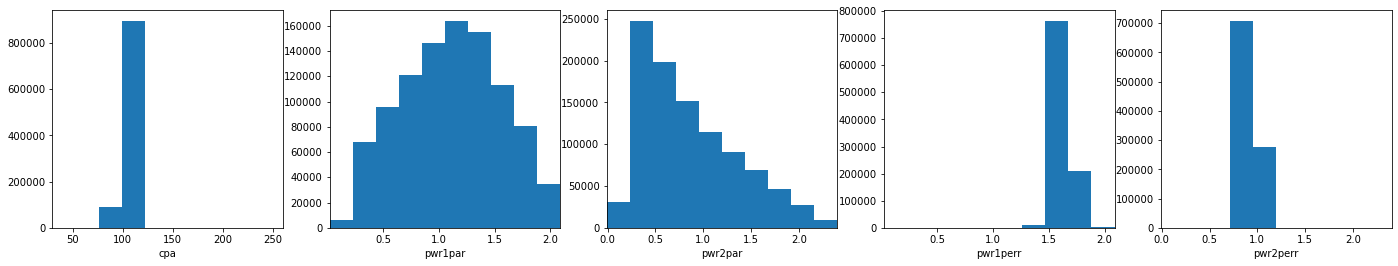

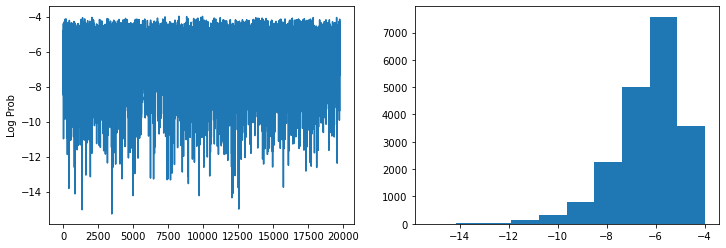

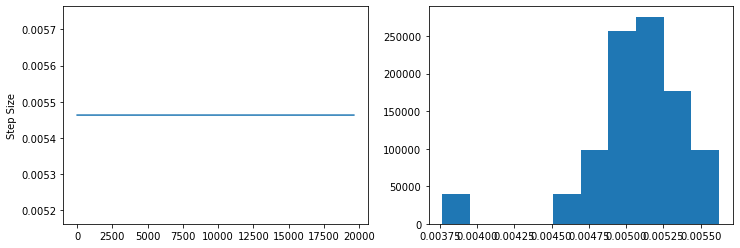

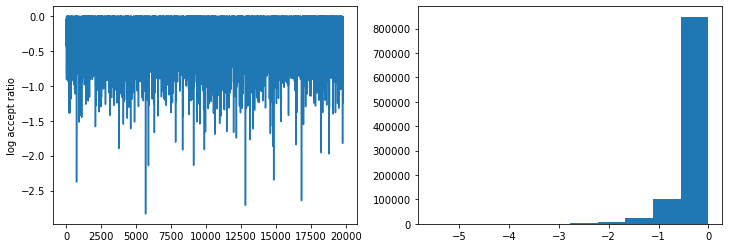

In [3]:
# Plot marginals.
plt.figure(1, figsize=(24, 4))
for i in range(samples.shape[1]):
    minmax = (utils.MIN_PARAMETERS[i] - .1*utils.RANGE_PARAMETERS[i], 
              utils.MAX_PARAMETERS[i] + 0.05*utils.RANGE_PARAMETERS[i])
    plt.subplot(1, samples.shape[1], i+1)
    plt.hist(samples[:, i], bins=10, range=minmax)
    plt.xlabel(utils.PARAMETERS[i])
    plt.xlim(minmax)
#plt.savefig(fname=f'{results_dir}/marginals_{unique_id}.pdf', bbox_inches='tight')

plt.figure(2, figsize=(12, 4))
x = np.loadtxt(glob(f'../../results/job_{jobid}/log_probs_*.csv')[0])
plt.subplot(1,2,1)
plt.plot(x)
plt.ylabel("Log Prob")
plt.subplot(1,2,2)
plt.hist(x)

plt.figure(3, figsize=(12, 4))
x = np.loadtxt(glob(f'../../results/job_{jobid}/stepsizes_*.csv')[0])
plt.subplot(1,2,1)
plt.plot(x)
plt.ylabel("Step Size")
plt.subplot(1,2,2)
x = np.concatenate([np.loadtxt(d) for d in glob(f'../../results/job_{jobid}/stepsizes_*.csv')], axis=0)
plt.hist(x)

plt.figure(4, figsize=(12, 4))
x = np.loadtxt(glob(f'../../results/job_{jobid}/logacceptratio_*.csv')[0])
plt.subplot(1,2,1)
plt.plot(x)
plt.ylabel("log accept ratio")
plt.subplot(1,2,2)
x = np.concatenate([np.loadtxt(d) for d in glob(f'../../results/job_{jobid}/logacceptratio_*.csv')], axis=0)
plt.hist(x)
print()

# Plot Marginals

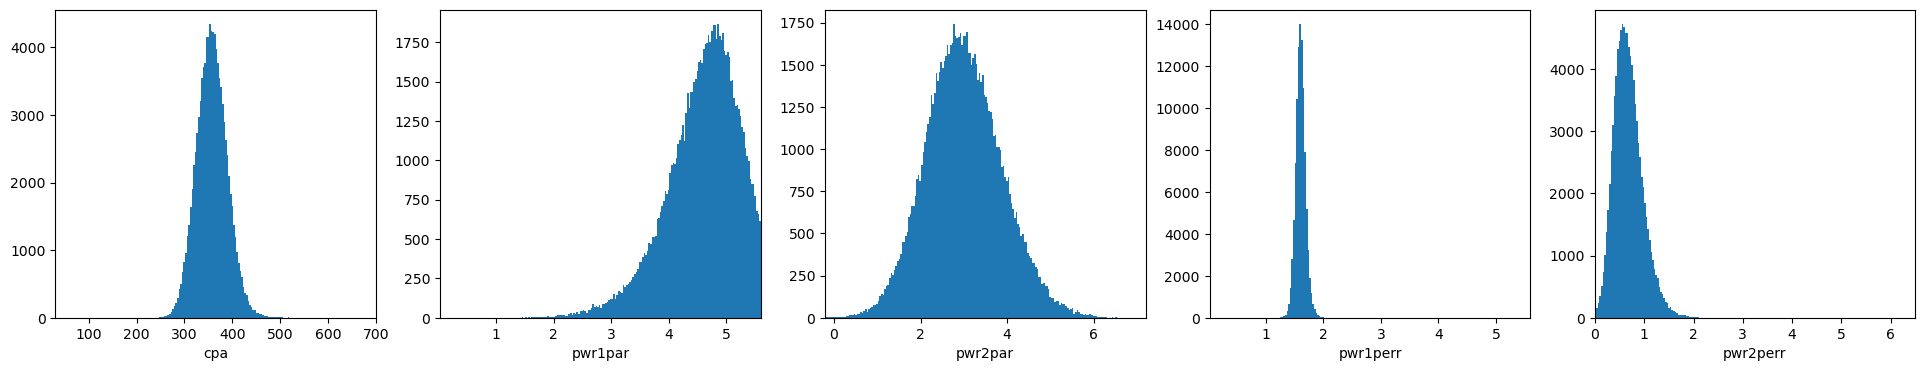

In [20]:
# Plot marginals.
samples = np.loadtxt(f'./for_claudio/samples_PAMELA_H-ApJL2018_20100103-20100130.csv')

plt.figure(1, figsize=(24, 4))
for i in range(samples.shape[1]):
    minmax = (utils.MIN_PARAMETERS[i] - .1*utils.RANGE_PARAMETERS[i], utils.MAX_PARAMETERS[i] + 2*utils.RANGE_PARAMETERS[i])
    plt.subplot(1, samples.shape[1], i+1)
    plt.hist(samples[:, i], bins=200, range=minmax)
    plt.xlabel(utils.PARAMETERS[i])
    plt.xlim(minmax)
#plt.savefig(fname=f'results/job_{jobid}/marginals.pdf', bbox_inches='tight')
#MIN, MAX, samples.min(axis=0), samples.max(axis=0)

# Plot step size distribution

(array([ 2.,  0.,  0.,  0.,  2.,  5., 13., 14.,  9.,  5.]),
 array([0.0037676 , 0.00395322, 0.00413884, 0.00432447, 0.00451009,
        0.00469572, 0.00488134, 0.00506697, 0.00525259, 0.00543821,
        0.00562384]),
 <BarContainer object of 10 artists>)

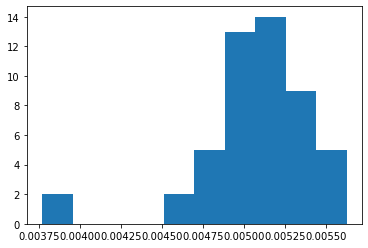

In [21]:
filenames = glob(f'../../results/job_{jobid}/stepsizes_*.csv')
sizes= []
for f in filenames:
    sizes.append(np.loadtxt(f)[0])
sizes = np.array(sizes)
plt.hist(sizes)
sizes.min(), sizes.max()

# Analyze auto correlation 

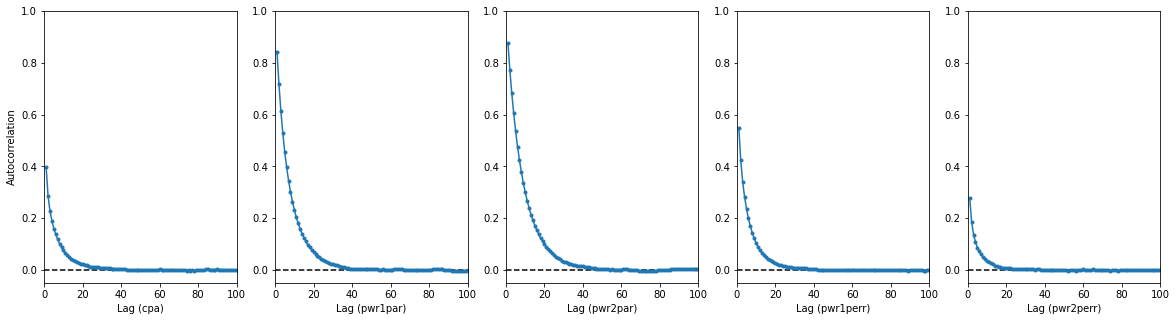

In [111]:
# See https://www.statlect.com/fundamentals-of-statistics/autocorrelation
import gcr_utils
import importlib
importlib.reload(gcr_utils)

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf#, acovf

max_lag = 100

plt.figure(1, figsize=(20,5))
for i in range(5):
    ax = plt.subplot(1,5,i+1)
    #plot_acf(samples[:100000, i], lags=range(1,100), alpha=None,title='', ax=ax, use_vlines=False)
    x = acf(samples[:, i], nlags=max_lag)
    plt.plot(range(1, max_lag+1), x[1:], marker='.')
    plt.ylim([-.05, 1])
    plt.xlim([0, max_lag])
    plt.hlines(y=0, xmin=0, xmax=max_lag, linestyles='--', color='k')
    plt.xlabel(f'Lag ({parameter_names[i]})')
    if i==0:
        plt.ylabel('Autocorrelation')
plt.savefig(f'autocorrelation.pdf', bbox_inches='tight')